In [1]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

import random
from scipy import sparse

In [2]:
df = pd.read_csv('train.csv')

In [3]:

def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text



In [4]:
def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict  

In [5]:
texts = [x for x in df['discourse_text']] #converting text into list 

In [6]:
texts=texts[0:300] #here i am using only first 300 words 

In [7]:
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

In [8]:

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
#X = sparse.csr_matrix(X) We can use this but for this approch i am not using it. 
#Y = sparse.csr_matrix(Y)

45414it [00:01, 37348.18it/s]


In [ ]:
X = tf.constant(X) #converting matrix to tensor
Y = tf.constant(Y)

In [ ]:
X.shape,Y.shape

In [ ]:

# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = tf.keras.layers.Input(shape=(X.shape[1],)) #input shape for my model
x = tf.keras.layers.Dense(units=embed_size, activation='linear')(inp) #
x = tf.keras.layers.Dense(units=Y.shape[1], activation='softmax')(x)
model = tf.keras.Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=10
    )

# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

In [ ]:
weights[0]

In [ ]:
model.summary()

In [ ]:
# The input layer 


# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

In [ ]:

# Ploting the embeddings
plt.figure(figsize=(20, 20))
for word in random.sample(list(unique_word_dict.keys()),150):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       


In [ ]:
embedding_dict

# With Pytorch 

Epoch: 1000 cost = 8.011655
Epoch: 2000 cost = 8.037224
Epoch: 3000 cost = 7.997386
Epoch: 4000 cost = 7.157965
Epoch: 5000 cost = 7.651793


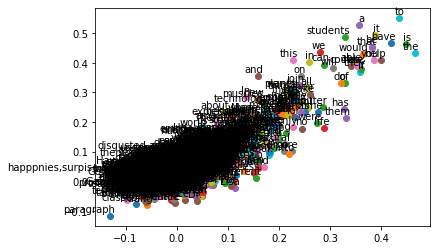

In [54]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def random_batch():
    '''
    Defing batch and input output 
    '''
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #taking random data 

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False) # voc_size > embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

if __name__ == '__main__':
    batch_size = 2 # mini-batch size
    embedding_size = 2 # embedding size

    
    sentences = texts 
    word_sequence = " ".join(sentences).split()
    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    voc_size = len(word_list)

    # Make skip gram of one size window
    skip_grams = []
    for i in range(1, len(word_sequence) - 1):
        target = word_dict[word_sequence[i]]
        context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
        for w in context:
            skip_grams.append([target, w])

    model = Word2Vec()

    criterion = nn.CrossEntropyLoss() # defing loff function 
    optimizer = optim.Adam(model.parameters(), lr=0.001) #defining optimizer

    # Training
    for epoch in range(5000): # model train 
        input_batch, target_batch = random_batch()
        input_batch = torch.Tensor(input_batch)
        target_batch = torch.LongTensor(target_batch)

        optimizer.zero_grad()
        output = model(input_batch)

        # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
        loss = criterion(output, target_batch)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()
    #visualize 
    for i, label in enumerate(word_list):
        W, WT = model.parameters()
        x, y = W[0][i].item(), W[1][i].item()
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()